## Part 1. Data Pre-Processing

In [1]:
#Import Necessary Packages

In [2]:
import pandas as pd
import numpy as np
import datetime
from sklearn import preprocessing,linear_model,datasets,svm,model_selection,naive_bayes,metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize,StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,precision_score,recall_score,f1_score,roc_curve,auc,roc_auc_score,log_loss,fbeta_score, make_scorer
import sklearn.neighbors as sk_neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Probit, MNLogit
from pylab import mpl
import plotly.graph_objects as go
import itertools
from scipy import interp
from pylab import mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
sns.set_style('whitegrid')
sns.set_context('paper')
import warnings
warnings.filterwarnings('ignore')
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE                
from imblearn.under_sampling import RandomUnderSampler  
from imblearn.over_sampling import RandomOverSampler                            
import imblearn.ensemble
from collections import Counter
imblearn.ensemble.EasyEnsembleClassifier()

EasyEnsembleClassifier()

In [3]:
#Import Data

In [4]:
price_info = pd.read_excel("ipo_firm_price_filtered.xlsx")
price_info.columns=['Code','Name','Date','Open','High','Low','Close','Quantity','Amount','Growth_rate','Change_rate','Market_cap','PE_ratio','IPO_date','IPO_date+2m']
print("Price_info Shape",price_info.shape)
IPO_info = pd.read_excel("ML_Data.xlsx")
print("IPO_info Shap",IPO_info.shape)
IPO_info=IPO_info[80:].reset_index().drop(columns=["index"])
#Total four boards：SSE/GEM/SZSE/STAR
board_info = pd.read_excel("4 board data.xlsx")
stock_names=IPO_info["Company_name"].unique()

Price_info Shape (89019, 15)
IPO_info Shap (2204, 47)


In [5]:
#Calculate IPO_Price and Before_OpenDay_Price of stocks

In [6]:
#If new stock can be traded at IPO day, then Before_OpenDay_Price is exactly IPO_Price
#If new stock cannot be traded at IPO day,which means it keeps at LimitUp_Price for a certain days,
#then Before_OpenDay_Price is equal to the Close_Price just the day before OpenDay
for i in range(len(IPO_info)):
    LimitUp_Days=IPO_info[IPO_info["Company_name"]==stock_names[i]]["No_of_days_stop"]
    if int(LimitUp_Days)==0:
        IPO_info.loc[i,"Before OpenDay Price"]=IPO_info.loc[i,"Issue_price"]
    else:
        IPO_info.loc[i,"Before OpenDay Price"]=float(price_info[price_info["Name"]==stock_names[i]].reset_index().loc[LimitUp_Days,"Close"])

In [7]:
#Calculate IPO_PE and Before_OpenDay_PE of stocks

In [8]:
#If new stock can be traded at IPO day, then Before_OpenDay_PE is exactly IPO_PE
#If new stock cannot be traded at IPO day,which means it keeps at LimitUp_Price for a certain days,
#then Before_OpenDay_PE is equal to the Current_PE just the day before OpenDay
for i in range(len(IPO_info)):
    LimitUp_Days=IPO_info[IPO_info["Company_name"]==stock_names[i]]["No_of_days_stop"]
    if int(LimitUp_Days)==0:
        IPO_info.loc[i,"Before OpenDay PE"]=IPO_info.loc[i,"Company_PE"]
    else:
        IPO_info.loc[i,"Before OpenDay PE"]=float(price_info[price_info["Name"]==stock_names[i]].reset_index().loc[LimitUp_Days,"PE_ratio"])

In [9]:
#Calculate IPO_MktCap and Before_OpenDay_MktCap of stocks

In [10]:
#If new stock can be traded at IPO day, then Before_OpenDay_MktCap is exactly IPO_MktCap
#If new stock cannot be traded at IPO day,which means it keeps at LimitUp_Price for a certain days,
#then Before_OpenDay_MkyCap is equal to the Current_MktCap just the day before OpenDay
IPO_info["IPO_MktCap"]=IPO_info["Total_stock_Issue_qty"]*IPO_info["Issue_price"]*10000
for i in range(len(IPO_info)):
    LimitUp_Days=IPO_info[IPO_info["Company_name"]==stock_names[i]]["No_of_days_stop"]
    if int(LimitUp_Days)==0:
        IPO_info.loc[i,"Before OpenDay MktCap"]=IPO_info.loc[i,"IPO_MktCap"]
    else:
        IPO_info.loc[i,"Before OpenDay MktCap"]=float(price_info[price_info["Name"]==stock_names[i]].reset_index().loc[LimitUp_Days,"Market_cap"])

In [11]:
#Calculate Board_Index_Trend between Before_IPO_1Day and After_Open_1Day 

In [12]:
#If Board_Index tends to grow during this period,then we set Mkt_Trend=1
#If Board_Index tends to be stable during this period,then we set Mkt_Trend=0
#If Board_Index tends to fall during this period,then we set Mkt_Trend=-1
for i in range(len(IPO_info)):
    LimitUp_Days=IPO_info[IPO_info["Company_name"]==stock_names[i]]["No_of_days_stop"]
    board_type=(IPO_info[IPO_info["Company_name"]==stock_names[i]]["Board_Type"]).values[0]
    IPO_date=str(IPO_info[IPO_info["Company_name"]==stock_names[i]]["IPO_date"].values)[2:12]
    IPO_index=float(board_info[board_info["Date"]==IPO_date][board_type].values[0])
    Open_index=float(board_info.iloc[board_info[board_info["Date"]==IPO_date].index[0]+LimitUp_Days][board_type].values[0])
    IPO_info.loc[i,"IPO_index"]=IPO_index
    IPO_info.loc[i,"Open_index"]=Open_index
for i in range(len(IPO_info)):
    IPO_info.loc[i,"Mkt Growth"]=IPO_info.loc[i,"Open_index"]/IPO_info.loc[i,"IPO_index"]-1
    if IPO_info.loc[i,"Mkt Growth"]>0:
        IPO_info.loc[i,"Mkt Trend"]=1
    elif IPO_info.loc[i,"Mkt Growth"]<0:
        IPO_info.loc[i,"Mkt Trend"]=-1
    else:
        IPO_info.loc[i,"Mkt Trend"]=0

In [13]:
#Classify the industries into three main sectors

In [14]:
#If stock industry belongs to "Agriculture",then we set Industry=1
#If stock industry belongs to "Industrial ",then we set Industry=2
#If stock industry belongs to "Services ",then we set Industry=3
for i in range(len(IPO_info["Industry"])):
    if IPO_info["Industry"][i]=="Daily Consumption":
        IPO_info.loc[i,"Industry_Class"]=1
    elif IPO_info["Industry"][i]=="Manufactory" or IPO_info["Industry"][i]=="Material" or IPO_info["Industry"][i]=="Vehicle" or IPO_info["Industry"][i]=="Semiconductor" or IPO_info["Industry"][i]=="Energy":
        IPO_info.loc[i,"Industry_Class"]=2
    else:
        IPO_info.loc[i,"Industry_Class"]=3

In [15]:
#Classify the board_type into four boards

In [16]:
#If stock industry belongs to "STAR",then we set Industry=1
#If stock industry belongs to "SSE ",then we set Industry=2
#If stock industry belongs to "GEM ",then we set Industry=3
#If stock industry belongs to "SZSE ",then we set Industry=4
for i in range(len(IPO_info)):
    if IPO_info["Board_Type"][i]=="STAR":
        IPO_info.loc[i,"Board_Class"]=1
    elif IPO_info["Board_Type"][i]=="SSE":
        IPO_info.loc[i,"Board_Class"]=2
    elif IPO_info["Board_Type"][i]=="GEM":
        IPO_info.loc[i,"Board_Class"]=3
    else:
        IPO_info.loc[i,"Board_Class"]=4

In [17]:
IPO_info["Board_Type"].unique()

array(['GEM', 'SSE', 'STAR', 'SZSE'], dtype=object)

In [18]:
#Get dummy_variables for "Industry" and "Board"

In [19]:
boards=pd.get_dummies(IPO_info["Board_Class"],prefix="board_=")
industries=pd.get_dummies(IPO_info["Industry_Class"],prefix="industry_=")
IPO_info=pd.concat([IPO_info,boards,industries],axis=1)

In [20]:
#Calculate stock return for certain period

In [21]:
def stock_cum_growth(data,stock_code,lock_period,period):
    df = data[data['Code']==stock_code].reset_index().drop("index",axis=1)
    start_price = df.loc[lock_period,"Close"]
    end_price = df.loc[lock_period+period,"Close"]
    cum_growth = end_price/start_price-1
    return cum_growth

In [22]:
#Get Y variables for 0/1 

In [23]:
#If stock return is higher than targeted_value, then we set Y=1
#If stock return is lower than targeted_value, then we set Y=0
def y_generater(data,stock_code,lock_period,period,target):
    df = data[data['Code']==stock_code].reset_index().drop("index",axis=1)
    start_price = df.loc[lock_period,"Close"]
    end_price = df.loc[lock_period+period,"Close"]
    cum_growth = end_price/start_price-1
    
    if cum_growth >= target:
        return 1
    else:
        return 0

In [24]:
#For our study,we want to find if we hold new stock for 10-days just after OpenDay,whether we can achieve return=10%
#Then we set period=10, target=0.1

In [25]:
for i in range(len(IPO_info)):
    stock_code=IPO_info.loc[i,"Code"]
    lock_period=IPO_info.loc[i,"No_of_days_stop"]
    #lock_period=0
    #set forward_looking=1
    period=10
    one_day_growth=stock_cum_growth(price_info, stock_code, lock_period, period)
    y1=y_generater(price_info, stock_code, lock_period, period,0.1)
    IPO_info.loc[i,"one_day_growth"]=one_day_growth
    IPO_info.loc[i,"Y1"]=y1

In [26]:
#Select certain 23-variables as X-variables and Y1 as Y-variable

In [27]:
IPO_info.columns

Index(['Code', 'Company_name', 'IPO_date', 'Month', 'No_of_days_stop',
       'Open_for_Purchase_Date', 'Board_Type', 'Issue_price', 'Company_PE',
       'Industry_PE', 'Total_stock_Issue_qty', 'New_stock_Issue_qty',
       'Existing_stock_transfer_qty', 'Offline_issue_qty', 'Online_Issue_qty',
       'Clawback_ratio', 'Offline_subscription_limit',
       'Online_subscription_limit', 'Expected_fundraising_amount',
       'Total_fundraising_amount', 'Net_fundraising_amount', 'Issuance_costs',
       'Issuance_cost_in_percentage', 'Existing_stock_Transfer_cost',
       'Existing_stock_Transfer_cost_in_percentage', 'Total_Issuance_cost',
       'Total_Issuance_cost_in_percentage', 'Guarantee_Fee', 'Audit_fee',
       'Legal_fee', 'Number_of_valid_subscription_accounts',
       'Number_of_valid_subscription_shares', 'Winning_rate',
       'Subscription_multiple', 'Allotment_method', 'Announcement_date',
       'Online_issuance_of frozen_funds',
       'Underwriters_subscribe_for_the_remain

In [28]:
selected_columns=["Month","No_of_days_stop","Issue_price","Industry_PE","Before OpenDay Price","Clawback_ratio","Before OpenDay PE","Total_Issuance_cost_in_percentage","face_value","IPO_MktCap","Before OpenDay MktCap","Mkt Trend","board_=_1.0","board_=_2.0","board_=_3.0","board_=_4.0","industry_=_1.0","industry_=_2.0","industry_=_3.0","Y1"]
len(selected_columns)

20

In [29]:
#Check correlation between these variables

In [30]:
#We can see that the correlations between these variables are almost relative small
IPO_info[selected_columns].corr()

,Month,No_of_days_stop,Issue_price,Industry_PE,Before OpenDay Price,Clawback_ratio,Before OpenDay PE,Total_Issuance_cost_in_percentage,face_value,IPO_MktCap,Before OpenDay MktCap,Mkt Trend,board_=_1.0,board_=_2.0,board_=_3.0,board_=_4.0,industry_=_1.0,industry_=_2.0,industry_=_3.0,Y1
Month,1.000000,-0.021682,0.021990,-0.027285,-0.018095,-0.018439,0.000642,-0.041526,-0.007566,0.031117,-0.001239,-0.081160,-0.035896,-0.008828,-0.003110,0.039845,-0.016249,-0.000588,0.007588,-0.114250
No_of_days_stop,-0.021682,1.000000,-0.336132,0.356992,0.463217,0.459998,0.538875,0.420796,0.027494,-0.165747,0.145807,0.091122,-0.331459,0.165507,0.043929,-0.011028,-0.022601,-0.020222,0.030088,-0.006382
Issue_price,0.021990,-0.336132,1.000000,0.029448,0.486986,-0.316043,-0.064224,-0.275805,0.017376,0.119592,-0.070963,-0.017840,0.290018,-0.202958,0.084153,-0.069572,0.002041,-0.079263,0.078913,-0.010574
Industry_PE,-0.027285,0.356992,0.029448,1.000000,0.332451,0.026475,0.291032,0.211058,0.010604,-0.088424,-0.034878,-0.038379,0.050961,-0.111664,0.131943,-0.063831,-0.026852,-0.184343,0.197134,0.047021
Before OpenDay Price,-0.018095,0.463217,0.486986,0.332451,1.000000,0.016498,0.343053,0.007728,0.038845,-0.027433,0.081955,0.086764,-0.069667,-0.081152,0.169274,-0.058520,-0.017109,-0.100832,0.108871,-0.012186
Clawback_ratio,-0.018439,0.459998,-0.316043,0.026475,0.016498,1.000000,0.125305,0.029667,0.027173,-0.007779,0.264724,0.037261,-0.307885,0.417232,-0.240879,0.018573,0.070081,0.031105,-0.061487,0.007579
Before OpenDay PE,0.000642,0.538875,-0.064224,0.291032,0.343053,0.125305,1.000000,0.231963,0.002333,-0.051618,0.033599,0.078560,0.005879,-0.014743,0.056804,-0.055303,-0.041888,-0.048816,0.067177,-0.002022
Total_Issuance_cost_in_percentage,-0.041526,0.420796,-0.275805,0.211058,0.007728,0.029667,0.231963,1.000000,0.034272,-0.344752,-0.255423,0.006974,-0.021339,-0.166104,0.187727,-0.015146,-0.026099,0.062993,-0.052176,0.065212
face_value,-0.007566,0.027494,0.017376,0.010604,0.038845,0.027173,0.002333,0.034272,1.000000,-0.276203,-0.019993,-0.007204,-0.097763,-0.000532,0.037982,0.024783,0.011096,-0.006951,0.002219,-0.002777
IPO_MktCap,0.031117,-0.165747,0.119592,-0.088424,-0.027433,-0.007779,-0.051618,-0.344752,-0.276203,1.000000,0.500457,-0.024203,0.079061,0.097275,-0.103941,-0.045986,0.005566,-0.056505,0.054485,-0.018604


In [31]:
ML_info=IPO_info[selected_columns]
ML_info.columns

Index(['Month', 'No_of_days_stop', 'Issue_price', 'Industry_PE',
       'Before OpenDay Price', 'Clawback_ratio', 'Before OpenDay PE',
       'Total_Issuance_cost_in_percentage', 'face_value', 'IPO_MktCap',
       'Before OpenDay MktCap', 'Mkt Trend', 'board_=_1.0', 'board_=_2.0',
       'board_=_3.0', 'board_=_4.0', 'industry_=_1.0', 'industry_=_2.0',
       'industry_=_3.0', 'Y1'],
      dtype='object')

In [32]:
num_row=ML_info.shape[0]
np.random.seed(20210624)
y1=ML_info.iloc[:,-1].values
x1=ML_info.iloc[:,:-1].values
#ML_info.shape
print(Counter(y1))
smo = SMOTE(random_state=42)
x1 = x1.astype('float64')
x1_smo, y1_smo = smo.fit_resample(x1, y1)
print(Counter(y1_smo))

Counter({0.0: 1703, 1.0: 421})
Counter({0.0: 1703, 1.0: 1703})


In [33]:
#We combine the data after over_sampling

In [34]:
data=pd.concat([pd.DataFrame(x1_smo),pd.DataFrame(y1_smo)],axis=1)
data.columns=['Month', 'No_of_days_stop', 'Issue_price', 'Industry_PE',
       'Before OpenDay Price', 'Clawback_ratio', 'Before OpenDay PE',
       'Total_Issuance_cost_in_percentage', 'face_value', 'IPO_MktCap',
       'Before OpenDay MktCap', 'Mkt Trend', 'board_=_1.0', 'board_=_2.0',
       'board_=_3.0', 'board_=_4.0', 'industry_=_1.0', 'industry_=_2.0',
       'industry_=_3.0', 'Y1']

## Part 2. Model Building

In [35]:
x1_train, x1_test, y1_train, y1_test = model_selection.train_test_split(data.iloc[:,:-1], data.iloc[:,-1].astype(int), test_size = 0.5, random_state = 2020)
min_max_scaler = preprocessing.MinMaxScaler()
x1_train = min_max_scaler.fit_transform(x1_train)
x1_test = min_max_scaler.transform(x1_test)

In [36]:
x1_train

array([[0.71945051, 0.        , 0.06314215, ..., 0.        , 0.63798521,
        0.36201479],
       [1.        , 0.        , 0.09803415, ..., 0.        , 0.        ,
        1.        ],
       [0.74760131, 0.27586207, 0.08016654, ..., 0.22361443, 0.77638557,
        0.        ],
       ...,
       [0.        , 0.03448276, 0.09108252, ..., 0.        , 1.        ,
        0.        ],
       [0.54545455, 0.24137931, 0.07541513, ..., 0.        , 1.        ,
        0.        ],
       [0.90909091, 0.13793103, 0.05995398, ..., 0.        , 0.        ,
        1.        ]])

### Model 1：Logistic Regression（LR）

In [37]:
#We use GridSearchCV method

In [71]:
fhalf_scorer = metrics.make_scorer(metrics.fbeta_score, beta = 0.5)
grid = model_selection.GridSearchCV(linear_model.LogisticRegression(solver = 'liblinear'),
                    param_grid = {'C': [1, 10, 100, 1000]}, scoring = fhalf_scorer, cv = 10)
grid.fit(x1_train, y1_train)

GridSearchCV(cv=10, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [1, 10, 100, 1000]},
             scoring=make_scorer(fbeta_score, beta=0.5))

In [72]:
grid.best_params_

{'C': 1}

In [73]:
logit1 = linear_model.LogisticRegression(C=1,solver = 'liblinear')
logit1.fit(x1_train, y1_train)
print('Logistic_Score:', logit1.score(x1_test, y1_test))
print('Logistic_Coefficients:', logit1.coef_)

Logistic_Score: 0.5713446858485026
Logistic_Coefficients: [[-1.04 -0.84 -0.69  1.21  0.1   0.33  0.23  1.01  0.24  0.08 -0.2   0.07
  -0.1  -0.43  0.29  0.13  0.37 -0.25 -0.24]]


In [74]:
y1_predict = logit1.predict(x1_test)
print("The confusion matrix of Y1:")
confusion_matrix(y1_test, y1_predict)

The confusion matrix of Y1:


array([[491, 363],
       [367, 482]], dtype=int64)

In [75]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[491 363]
 [367 482]]


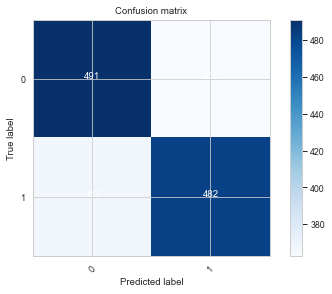

In [76]:
confmat1 = confusion_matrix(y_true=y1_test, y_pred=logit1.predict(x1_test))
labels = ['0','1']
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confmat1, classes=labels, title='Confusion matrix')
plt.savefig("CM_LR_10",dpi=300)

In [77]:
#Performance Evaluation

In [78]:
Precision_log1=precision_score(y1_test, y1_predict,average="binary")
print("Precision for Y1:",Precision_log1)
Recall_log1=recall_score(y1_test, y1_predict)
print("Recall for Y1:",Recall_log1)
F1_log1=f1_score(y1_test, y1_predict)
print("F1_score for Y1:",F1_log1)
fhalf_log1 = metrics.fbeta_score(y1_test, y1_predict, beta = 0.5)
print('F0.5 score for Y1:', fhalf_log1)
lr1_proba = logit1.predict_proba(x1_test)
lr_1_proba=lr1_proba[:,1]
AUC_log1=roc_auc_score(y1_test, lr_1_proba)
print("Area_Under_Curve for Y1:",AUC_log1)
LL_log1=log_loss(y1_test,y1_predict,eps=1e-15, normalize=True, sample_weight=None, labels=None)
print("Log_Loss for Y1:",LL_log1)
LR1=[Precision_log1,Recall_log1,F1_log1,fhalf_log1,AUC_log1,LL_log1]
LR_performance_matrix1=pd.DataFrame({"Y1":LR1},index=["Precision_Score","Recall_Score","F1_Score","F0.5_Score","AUC","Log_Loss"])
LR_performance_matrix1=pd.DataFrame(LR_performance_matrix1.stack(),columns=["LR"])
LR_performance_matrix1

Precision for Y1: 0.570414201183432
Recall for Y1: 0.5677267373380448
F1_score for Y1: 0.5690672963400236
F0.5 score for Y1: 0.5698746748640341
Area_Under_Curve for Y1: 0.5959442573298797
Log_Loss for Y1: 14.805400482766858


,,LR
Precision_Score,Y1,0.570414
Recall_Score,Y1,0.567727
F1_Score,Y1,0.569067
F0.5_Score,Y1,0.569875
AUC,Y1,0.595944
Log_Loss,Y1,14.805400


In [46]:
#Plot ROC(receiver operating characteristic curve)

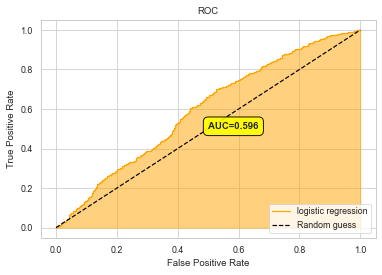

In [79]:
fprs_log1, tprs_log1, thresholds_log1 = roc_curve(y1_test, lr_1_proba)
plt.plot(fprs_log1, tprs_log1,color='orange',label='logistic regression')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0,1],[0,1],'--',color='black',label='Random guess')
plt.annotate(f"AUC={round(AUC_log1,3)}",(0.5,0.5),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy')
plt.fill_between(fprs_log1,tprs_log1,color='orange',alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig("ROC_LR_10",dpi=300)

### Model 2: Random Foreset（RF）

In [48]:
min_samples_leaf=list(np.arange(25,35,1))
max_depth=list(np.arange(5,15,1))
n_estimators=list(np.arange(35,45,1))
param_grid = dict(min_samples_leaf = min_samples_leaf,max_depth = max_depth, n_estimators = n_estimators)
rf=RandomForestClassifier(class_weight='balanced',random_state=100)
kflod = StratifiedKFold(n_splits=10, shuffle = True,random_state=10)
grid_search = GridSearchCV(rf,param_grid,scoring = 'roc_auc',cv = kflod)
grid_search.fit(x1_train,y1_train)
grid_search.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=9,
                       min_samples_leaf=26, n_estimators=43, random_state=100)

In [80]:
rf1=RandomForestClassifier(max_depth=9,min_samples_leaf=27,n_estimators=43,class_weight='balanced',random_state=100)
rf1.fit(x1_train,y1_train)
print("RF score for Y1:",rf1.score(x1_test,y1_test))

RF score for Y1: 0.8338226658837345


In [81]:
y1_predict = rf1.predict(x1_test)
print("The confusion matrix of Y1:")
confusion_matrix(y1_test, y1_predict)

The confusion matrix of Y1:


array([[821,  33],
       [250, 599]], dtype=int64)

Confusion matrix, without normalization
[[821  33]
 [250 599]]


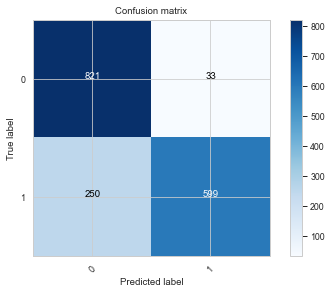

In [82]:
confmat1 = confusion_matrix(y_true=y1_test, y_pred=rf1.predict(x1_test))
labels = ['0','1']
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confmat1, classes=labels, title='Confusion matrix')
plt.savefig("CM_RF_10",dpi=300)

In [83]:
Precision_rf1=precision_score(y1_test, y1_predict,average="binary")
print("Precision for Y1:",Precision_rf1)
Recall_rf1=recall_score(y1_test, y1_predict)
print("Recall for Y1:",Recall_rf1)
F1_rf1=f1_score(y1_test, y1_predict)
print("F1_score for Y1:",F1_rf1)
fhalf_rf1 = metrics.fbeta_score(y1_test, y1_predict, beta = 0.5)
print('F0.5 score for Y1:', fhalf_rf1)
rf1_proba = rf1.predict_proba(x1_test)
rf_1_proba=rf1_proba[:,1]
AUC_rf1=roc_auc_score(y1_test, rf_1_proba)
print("Area_Under_Curve for Y1:",AUC_rf1)
LL_rf1=log_loss(y1_test,y1_predict,eps=1e-15, normalize=True, sample_weight=None, labels=None)
print("Log_Loss for Y1:",LL_rf1)
RF1=[Precision_rf1,Recall_rf1,F1_rf1,fhalf_rf1,AUC_rf1,LL_rf1]
RF_performance_matrix1=pd.DataFrame({"Y1":RF1},index=["Precision_Score","Recall_Score","F1_Score","F0.5_Score","AUC","Log_Loss"])
RF_performance_matrix1=pd.DataFrame(RF_performance_matrix1.stack(),columns=["RF"])
RF_performance_matrix1

Precision for Y1: 0.9477848101265823
Recall for Y1: 0.7055359246171967
F1_score for Y1: 0.8089128966914247
F0.5 score for Y1: 0.8868818477939001
Area_Under_Curve for Y1: 0.8919709921853235
Log_Loss for Y1: 5.739577279198427


,,RF
Precision_Score,Y1,0.947785
Recall_Score,Y1,0.705536
F1_Score,Y1,0.808913
F0.5_Score,Y1,0.886882
AUC,Y1,0.891971
Log_Loss,Y1,5.739577


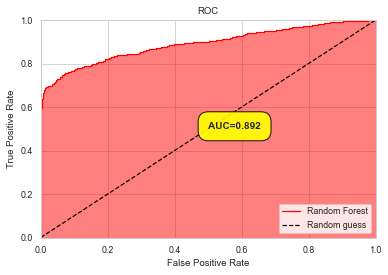

In [84]:
fprs_rf1, tprs_rf1, thresholds1 = roc_curve(y1_test, rf_1_proba)
plt.plot(fprs_rf1,tprs_rf1,color='red',label='Random Forest')
plt.plot([0,1],[0,1],'--',color='black',label='Random guess')
plt.legend(fontsize=20)
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.annotate(f"AUC={round(AUC_rf1,3)}",(0.5,0.5),bbox=dict(boxstyle='round,pad=1', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy',size=10)
plt.fill_between(fprs_rf1,tprs_rf1,color='red',alpha=0.5)
plt.savefig('ROC_RF_10',dpi=300)

### Model 3: Support Vector Machine（SVM）

In [54]:
C=list(np.arange(0,100,1))
gamma=list(np.arange(0.5,2,0.5))
param_grid = dict(C=C,gamma=gamma)

In [55]:
svm=SVC(kernel='rbf',probability=True,class_weight='balanced',random_state=100)
kflod = StratifiedKFold(n_splits=10, shuffle = True,random_state=10)
grid_search = GridSearchCV(svm,param_grid,scoring = 'roc_auc',cv = kflod)
grid_search.fit(x1_train,y1_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             estimator=SVC(class_weight='balanced', probability=True,
                           random_state=100),
             param_grid={'C': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                               15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
                               27, 28, 29, ...],
                         'gamma': [0.5, 1.0, 1.5]},
             scoring='roc_auc')

In [56]:
grid_search.best_estimator_

SVC(C=58, class_weight='balanced', gamma=1.0, probability=True,
    random_state=100)

In [127]:
svm1=SVC(kernel='rbf',C=58,class_weight='balanced',gamma=1,probability=True,random_state=100)
svm1.fit(x1_train,y1_train)
print("SVM score for Y1:",svm1.score(x1_test,y1_test))

SVM score for Y1: 0.8402818555490311


In [128]:
y1_predict = svm1.predict(x1_test)
print("The confusion matrix of Y1:")
confusion_matrix(y1_test, y1_predict)

The confusion matrix of Y1:


array([[756,  98],
       [174, 675]], dtype=int64)

Confusion matrix, without normalization
[[756  98]
 [174 675]]


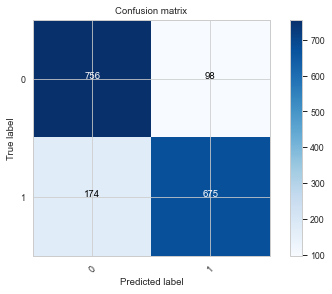

In [129]:
confmat1 = confusion_matrix(y_true=y1_test, y_pred=svm1.predict(x1_test))
labels = ['0','1']
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confmat1, classes=labels, title='Confusion matrix')
plt.savefig("CM_SVM_10",dpi=300)

In [130]:
Precision_svm1=precision_score(y1_test, y1_predict,average="binary")
print("Precision for Y1:",Precision_svm1)
Recall_svm1=recall_score(y1_test, y1_predict)
print("Recall for Y1:",Recall_svm1)
F1_svm1=f1_score(y1_test, y1_predict)
print("F1_score for Y1:",F1_svm1)
fhalf_svm1 = metrics.fbeta_score(y1_test, y1_predict, beta = 0.5)
print('F0.5 score for Y1:', fhalf_svm1)
svm1_proba = svm1.predict_proba(x1_test)
svm_1_proba=svm1_proba[:,1]
AUC_svm1=roc_auc_score(y1_test, svm_1_proba)
print("Area_Under_Curve for Y1:",AUC_svm1)
LL_svm1=log_loss(y1_test,y1_predict,eps=1e-15, normalize=True, sample_weight=None, labels=None)
print("Log_Loss for Y1:",LL_svm1)
SVM1=[Precision_svm1,Recall_svm1,F1_svm1,fhalf_svm1,AUC_svm1,LL_svm1]
SVM_performance_matrix1=pd.DataFrame({"Y1":SVM1},index=["Precision_Score","Recall_Score","F1_Score","F0.5_Score","AUC","Log_Loss"])
SVM_performance_matrix1=pd.DataFrame(SVM_performance_matrix1.stack(),columns=["SVM"])
SVM_performance_matrix1

Precision for Y1: 0.8732212160413971
Recall for Y1: 0.7950530035335689
F1_score for Y1: 0.8323057953144266
F0.5 score for Y1: 0.8563816290281654
Area_Under_Curve for Y1: 0.8946080662468312
Log_Loss for Y1: 5.5165152906423165


,,SVM
Precision_Score,Y1,0.873221
Recall_Score,Y1,0.795053
F1_Score,Y1,0.832306
F0.5_Score,Y1,0.856382
AUC,Y1,0.894608
Log_Loss,Y1,5.516515


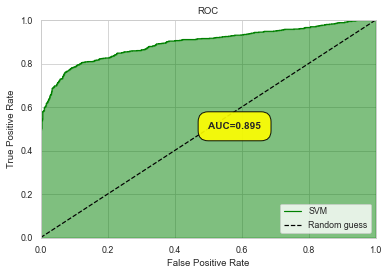

In [131]:
fprs_svm1, tprs_svm1, thresholds1 = roc_curve(y1_test, svm_1_proba)
plt.plot(fprs_svm1, tprs_svm1,color='green',label='SVM')
plt.plot([0,1],[0,1],'--',color='black',label='Random guess')
plt.legend(fontsize=20)
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.annotate(f"AUC={round(AUC_svm1,3)}",(0.5,0.5),bbox=dict(boxstyle='round,pad=1', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy',size=10)
plt.fill_between(fprs_svm1,tprs_svm1,color='green',alpha=0.5)
plt.savefig('ROC_SVM_10',dpi=300)

### Model 4：K-Nearest Neighbor（KNN）

In [62]:
n_neighbors=list(np.arange(0,100,1))
param_grid = dict(n_neighbors=n_neighbors)
knn=KNeighborsClassifier()
kflod = StratifiedKFold(n_splits=10, shuffle = True,random_state=10)
grid_search = GridSearchCV(knn,param_grid,scoring = 'roc_auc',cv = kflod)
grid_search.fit(x1_train,y1_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                         12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                                         22, 23, 24, 25, 26, 27, 28, 29, ...]},
             scoring='roc_auc')

In [132]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [133]:
knn1=KNeighborsClassifier(n_neighbors=3)
knn1.fit(x1_train,y1_train)
print("KNN score for Y1:",knn1.score(x1_test,y1_test))

KNN score for Y1: 0.7874339401056958


In [134]:
y1_predict = knn1.predict(x1_test)
print("The confusion matrix of Y1:")
confusion_matrix(y1_test, y1_predict)

The confusion matrix of Y1:


array([[697, 157],
       [205, 644]], dtype=int64)

Confusion matrix, without normalization
[[697 157]
 [205 644]]


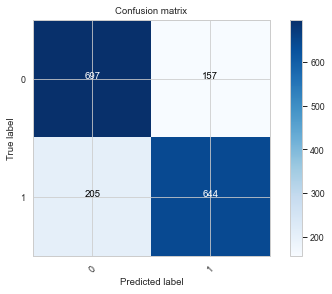

In [135]:
confmat1 = confusion_matrix(y_true=y1_test, y_pred=knn1.predict(x1_test))
labels = ['0','1']
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confmat1, classes=labels, title='Confusion matrix')
plt.savefig("CM_KNN_10",dpi=300)

In [136]:
Precision_knn1=precision_score(y1_test, y1_predict,average="binary")
print("Precision for Y1:",Precision_knn1)
Recall_knn1=recall_score(y1_test, y1_predict)
print("Recall for Y1:",Recall_knn1)
F1_knn1=f1_score(y1_test, y1_predict)
print("F1_score for Y1:",F1_knn1)
fhalf_knn1 = metrics.fbeta_score(y1_test, y1_predict, beta = 0.5)
print('F0.5 score for Y1:', fhalf_knn1)
knn1_proba = knn1.predict_proba(x1_test)
knn_1_proba=knn1_proba[:,1]
AUC_knn1=roc_auc_score(y1_test, knn_1_proba)
print("Area_Under_Curve for Y1:",AUC_knn1)
LL_knn1=log_loss(y1_test,y1_predict,eps=1e-15, normalize=True, sample_weight=None, labels=None)
print("Log_Loss for Y1:",LL_knn1)
KNN1=[Precision_knn1,Recall_knn1,F1_knn1,fhalf_knn1,AUC_knn1,LL_knn1]
KNN_performance_matrix1=pd.DataFrame({"Y1":KNN1},index=["Precision_Score","Recall_Score","F1_Score","F0.5_Score","AUC","Log_Loss"])
KNN_performance_matrix1=pd.DataFrame(KNN_performance_matrix1.stack(),columns=["KNN"])
KNN_performance_matrix1

Precision for Y1: 0.8039950062421972
Recall for Y1: 0.7585394581861012
F1_score for Y1: 0.7806060606060605
F0.5 score for Y1: 0.7944732297063904
Area_Under_Curve for Y1: 0.8544844051273988
Log_Loss for Y1: 7.341845326925548


,,KNN
Precision_Score,Y1,0.803995
Recall_Score,Y1,0.758539
F1_Score,Y1,0.780606
F0.5_Score,Y1,0.794473
AUC,Y1,0.854484
Log_Loss,Y1,7.341845


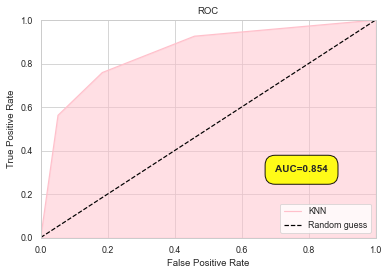

In [137]:
fprs_knn1, tprs_knn1, thresholds1 = roc_curve(y1_test, knn_1_proba)
plt.plot(fprs_knn1, tprs_knn1,color='pink',label='KNN')
plt.plot([0,1],[0,1],'--',color='black',label='Random guess')
plt.legend(fontsize=20)
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.annotate(f"AUC={round(AUC_knn1,3)}",(0.7,0.3),bbox=dict(boxstyle='round,pad=1', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy',size=10)
plt.fill_between(fprs_knn1,tprs_knn1,color='pink',alpha=0.5)
plt.savefig('ROC_KNN_10',dpi=300)

### Model 5：Multilayer Perceptron（MLP）

In [96]:
mlp_clf__tuned_parameters = {"hidden_layer_sizes": [(100,), (100, 30)],
                             "solver": ['adam', 'sgd', 'lbfgs'],
                             "max_iter": [20],
                             "verbose": [True]
                             }
mlp = MLPClassifier()
estimator = GridSearchCV(mlp, mlp_clf__tuned_parameters, n_jobs=6)
estimator.fit(x1_train, y1_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=6,
             param_grid={'hidden_layer_sizes': [(100,), (100, 30)],
                         'max_iter': [20], 'solver': ['adam', 'sgd', 'lbfgs'],
                         'verbose': [True]})

In [138]:
estimator.best_params_

{'hidden_layer_sizes': (100,),
 'max_iter': 20,
 'solver': 'lbfgs',
 'verbose': True}

In [139]:
mlp1=MLPClassifier(hidden_layer_sizes=(100),max_iter=20,solver="lbfgs",verbose=True,random_state=100)
mlp1.fit(x1_train,y1_train)
print("MLP score for Y1:",mlp1.score(x1_test,y1_test))

MLP score for Y1: 0.726952436876101


In [140]:
y1_predict = mlp1.predict(x1_test)
print("The confusion matrix of Y1:")
confusion_matrix(y1_test, y1_predict)

The confusion matrix of Y1:


array([[659, 195],
       [270, 579]], dtype=int64)

Confusion matrix, without normalization
[[659 195]
 [270 579]]


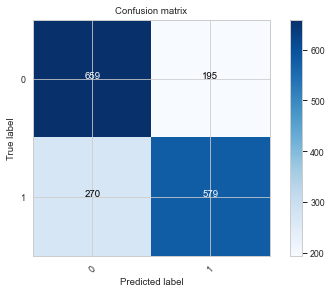

In [141]:
confmat1 = confusion_matrix(y_true=y1_test, y_pred=mlp1.predict(x1_test))
labels = ['0','1']
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confmat1, classes=labels, title='Confusion matrix')
plt.savefig("CM_MLP_10",dpi=300)

In [142]:
Precision_mlp1=precision_score(y1_test, y1_predict,average="binary")
print("Precision for Y1:",Precision_mlp1)
Recall_mlp1=recall_score(y1_test, y1_predict)
print("Recall for Y1:",Recall_mlp1)
F1_mlp1=f1_score(y1_test, y1_predict)
print("F1_score for Y1:",F1_mlp1)
fhalf_mlp1 = metrics.fbeta_score(y1_test, y1_predict, beta = 0.5)
print('F0.5 score for Y1:', fhalf_mlp1)
mlp1_proba = mlp1.predict_proba(x1_test)
mlp_1_proba=mlp1_proba[:,1]
AUC_mlp1=roc_auc_score(y1_test, mlp_1_proba)
print("Area_Under_Curve for Y1:",AUC_mlp1)
LL_mlp1=log_loss(y1_test,y1_predict,eps=1e-15, normalize=True, sample_weight=None, labels=None)
print("Log_Loss for Y1:",LL_mlp1)
MLP1=[Precision_mlp1,Recall_mlp1,F1_mlp1,fhalf_mlp1,AUC_mlp1,LL_mlp1]
MLP_performance_matrix1=pd.DataFrame({"Y1":MLP1},index=["Precision_Score","Recall_Score","F1_Score","F0.5_Score","AUC","Log_Loss"])
MLP_performance_matrix1=pd.DataFrame(MLP_performance_matrix1.stack(),columns=["MLP"])
MLP_performance_matrix1

Precision for Y1: 0.748062015503876
Recall for Y1: 0.6819787985865724
F1_score for Y1: 0.7134935304990758
F0.5 score for Y1: 0.7338403041825095
Area_Under_Curve for Y1: 0.7942171944952457
Log_Loss for Y1: 9.430820284869263


,,MLP
Precision_Score,Y1,0.748062
Recall_Score,Y1,0.681979
F1_Score,Y1,0.713494
F0.5_Score,Y1,0.733840
AUC,Y1,0.794217
Log_Loss,Y1,9.430820


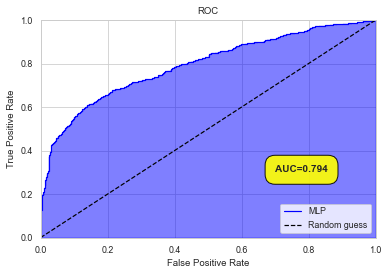

In [143]:
fprs_mlp1, tprs_mlp1, thresholds1 = roc_curve(y1_test, mlp_1_proba)
plt.plot(fprs_mlp1, tprs_mlp1,color='blue',label='MLP')
plt.plot([0,1],[0,1],'--',color='black',label='Random guess')
plt.legend(fontsize=20)
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.annotate(f"AUC={round(AUC_mlp1,3)}",(0.7,0.3),bbox=dict(boxstyle='round,pad=1', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy',size=10)
plt.fill_between(fprs_mlp1,tprs_mlp1,color='blue',alpha=0.5)
plt.savefig('ROC_MLP_10',dpi=300)

### Model 6：Gaussian Naive Bayes（Gaussian NB）

In [144]:
nb1=GaussianNB(priors=None,var_smoothing=1e-09)
nb1.fit(x1_train,y1_train)
print("Gaussian NB score for Y1:",nb1.score(x1_test,y1_test))

Gaussian NB score for Y1: 0.5366999412800939


In [145]:
y1_predict = nb1.predict(x1_test)
print("The confusion matrix of Y1:")
confusion_matrix(y1_test, y1_predict)

The confusion matrix of Y1:


array([[134, 720],
       [ 69, 780]], dtype=int64)

Confusion matrix, without normalization
[[134 720]
 [ 69 780]]


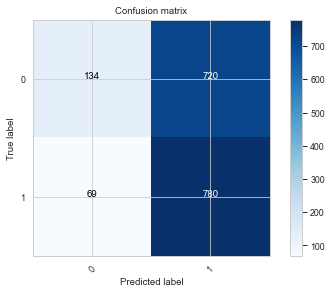

In [146]:
confmat1 = confusion_matrix(y_true=y1_test, y_pred=nb1.predict(x1_test))
labels = ['0','1']
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confmat1, classes=labels, title='Confusion matrix')
plt.savefig("CM_NB_10",dpi=300)

In [147]:
Precision_nb1=precision_score(y1_test, y1_predict,average="binary")
print("Precision for Y1:",Precision_nb1)
Recall_nb1=recall_score(y1_test, y1_predict)
print("Recall for Y1:",Recall_nb1)
F1_nb1=f1_score(y1_test, y1_predict)
print("F1_score for Y1:",F1_nb1)
fhalf_nb1 = metrics.fbeta_score(y1_test, y1_predict, beta = 0.5)
print('F0.5 score for Y1:', fhalf_nb1)
nb1_proba = nb1.predict_proba(x1_test)
nb_1_proba=nb1_proba[:,1]
AUC_nb1=roc_auc_score(y1_test, nb_1_proba)
print("Area_Under_Curve for Y1:",AUC_nb1)
LL_nb1=log_loss(y1_test,y1_predict,eps=1e-15, normalize=True, sample_weight=None, labels=None)
print("Log_Loss for Y1:",LL_nb1)
NB1=[Precision_nb1,Recall_nb1,F1_nb1,fhalf_nb1,AUC_nb1,LL_nb1]
NB_performance_matrix1=pd.DataFrame({"Y1":NB1},index=["Precision_Score","Recall_Score","F1_Score","F0.5_Score","AUC","Log_Loss"])
NB_performance_matrix1=pd.DataFrame(NB_performance_matrix1.stack(),columns=["NB"])
NB_performance_matrix1

Precision for Y1: 0.52
Recall for Y1: 0.9187279151943463
F1_score for Y1: 0.6641123882503194
F0.5 score for Y1: 0.5694261936049059
Area_Under_Curve for Y1: 0.6483519666338411
Log_Loss for Y1: 16.00215518833486


,,NB
Precision_Score,Y1,0.520000
Recall_Score,Y1,0.918728
F1_Score,Y1,0.664112
F0.5_Score,Y1,0.569426
AUC,Y1,0.648352
Log_Loss,Y1,16.002155


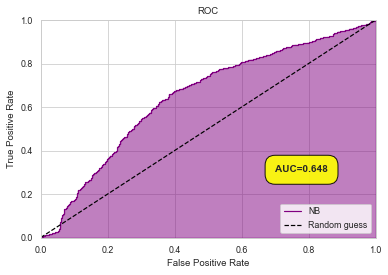

In [148]:
fprs_nb1, tprs_nb1, thresholds1 = roc_curve(y1_test, nb_1_proba)
plt.plot(fprs_nb1, tprs_nb1,color='purple',label='NB')
plt.plot([0,1],[0,1],'--',color='black',label='Random guess')
plt.legend(fontsize=20)
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.annotate(f"AUC={round(AUC_nb1,3)}",(0.7,0.3),bbox=dict(boxstyle='round,pad=1', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy',size=10)
plt.fill_between(fprs_nb1,tprs_nb1,color='purple',alpha=0.5)
plt.savefig('ROC_NB_10',dpi=300)

### Part 3.Model Comparision

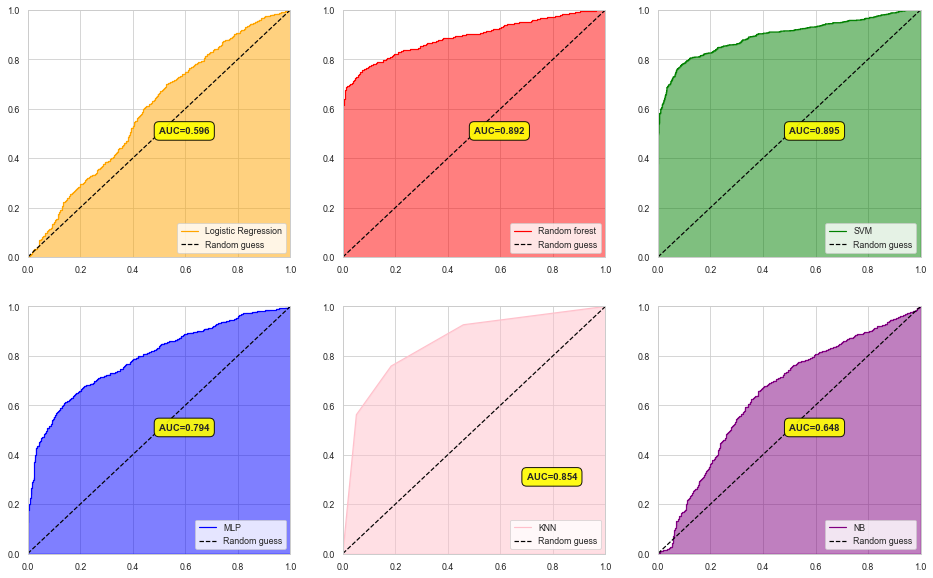

In [149]:
fig , axes=plt.subplots(2,3,figsize=(16,10))

axes[0,0].plot(fprs_log1,tprs_log1,color='orange',label='Logistic Regression')
axes[0,0].plot([0,1],[0,1],'--',color='black',label='Random guess')
axes[0,0].legend(loc="lower right")
axes[0,0].set_ylim(0,1)
axes[0,0].set_xlim(0,1)
axes[0,0].annotate(f"AUC={round(AUC_log1,3)}",(0.5,0.5),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy')
axes[0,0].fill_between(fprs_log1,tprs_log1,color='orange',alpha=0.5)

axes[0,1].plot(fprs_rf1,tprs_rf1,color='red',label='Random forest')
axes[0,1].plot([0,1],[0,1],'--',color='black',label='Random guess')
axes[0,1].legend(loc="lower right")
axes[0,1].set_ylim(0,1)
axes[0,1].set_xlim(0,1)
axes[0,1].annotate(f"AUC={round(AUC_rf1,3)}",(0.5,0.5),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy')
axes[0,1].fill_between(fprs_rf1,tprs_rf1,color='red',alpha=0.5)

axes[0,2].plot(fprs_svm1, tprs_svm1,color='green',label='SVM')
axes[0,2].plot([0,1],[0,1],'--',color='black',label='Random guess')
axes[0,2].legend(loc="lower right")
axes[0,2].set_ylim(0,1)
axes[0,2].set_xlim(0,1)
axes[0,2].annotate(f"AUC={round(AUC_svm1,3)}",(0.5,0.5),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy')
axes[0,2].fill_between(fprs_svm1,tprs_svm1,color='green',alpha=0.5)

axes[1,0].plot(fprs_mlp1,tprs_mlp1,label='MLP',color='blue')
axes[1,0].plot([0,1],[0,1],'--',color='black',label='Random guess')
axes[1,0].legend(loc="lower right")
axes[1,0].set_ylim(0,1)
axes[1,0].set_xlim(0,1)
axes[1,0].annotate(f"AUC={round(AUC_mlp1,3)}",(0.5,0.5),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy')
axes[1,0].fill_between(fprs_mlp1,tprs_mlp1,color='blue',alpha=0.5)

axes[1,1].plot(fprs_knn1,tprs_knn1,label='KNN',color='pink')
axes[1,1].plot([0,1],[0,1],'--',color='black',label='Random guess')
axes[1,1].legend(loc="lower right")
axes[1,1].set_ylim(0,1)
axes[1,1].set_xlim(0,1)
axes[1,1].annotate(f"AUC={round(AUC_knn1,3)}",(0.7,0.3),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy')
axes[1,1].fill_between(fprs_knn1,tprs_knn1,color='pink',alpha=0.5)

axes[1,2].plot(fprs_nb1,tprs_nb1,label='NB',color='purple')
axes[1,2].plot([0,1],[0,1],'--',color='black',label='Random guess')
axes[1,2].legend(loc="lower right")
axes[1,2].set_ylim(0,1)
axes[1,2].set_xlim(0,1)
axes[1,2].annotate(f"AUC={round(AUC_nb1,3)}",(0.5,0.5),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.9),weight='heavy')
axes[1,2].fill_between(fprs_nb1,tprs_nb1,color='purple',alpha=0.5)
fig.savefig('Model_Comparison_10',dpi=300)

In [150]:
Performance_Matrix=pd.concat([LR_performance_matrix1,RF_performance_matrix1,SVM_performance_matrix1,MLP_performance_matrix1,KNN_performance_matrix1,NB_performance_matrix1],axis=1)
Performance_Matrix

,,LR,RF,SVM,MLP,KNN,NB
Precision_Score,Y1,0.570414,0.947785,0.873221,0.748062,0.803995,0.520000
Recall_Score,Y1,0.567727,0.705536,0.795053,0.681979,0.758539,0.918728
F1_Score,Y1,0.569067,0.808913,0.832306,0.713494,0.780606,0.664112
F0.5_Score,Y1,0.569875,0.886882,0.856382,0.733840,0.794473,0.569426
AUC,Y1,0.595944,0.891971,0.894608,0.794217,0.854484,0.648352
Log_Loss,Y1,14.805400,5.739577,5.516515,9.430820,7.341845,16.002155
